In [ ]:

import nltk
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

DATA_PATH = "preprocessed_data.csv"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
df = pd.read_csv(DATA_PATH)

df.head()

,title,genre,director,plot
0,1 fan a darkomentary,comedy,dee austin robertson,donnie darko super fan darryl donaldson makes ...
1,exce,comedy,jim enright,debi diamond climbs the corporate ladder the h...
2,nettirwnu,drama,kaare andrews,andrew herberts is a unpublished author nearin...
3,15,drama,royston tan,this is the first movie ive seen from singapor...
4,68,drama,steven kovacs,covers exactly one year january st through de...


In [ ]:
df.describe()

,title,genre,director,plot
count,29999,30000,30000,30000
unique,29931,3,15697,29980
top,good night nurse,comedy,jules white,onetime rocknroll star bobby rivers discovers ...
freq,3,10000,134,4


# Preprocessing

In [ ]:
def remove_stopwords(sentence: str)-> str:
    if sentence is not str:
        sentence = str(sentence)
    tokens = word_tokenize(sentence)
    tokens = [t for t in tokens if t not in set(stopwords.words('english'))]
    return " ".join(tokens)


In [ ]:
df = df.map(lambda x: str(x))

In [ ]:
df.head()

,title,genre,director,plot
0,1 fan a darkomentary,comedy,dee austin robertson,donnie darko super fan darryl donaldson makes ...
1,exce,comedy,jim enright,debi diamond climbs the corporate ladder the h...
2,nettirwnu,drama,kaare andrews,andrew herberts is a unpublished author nearin...
3,15,drama,royston tan,this is the first movie ive seen from singapor...
4,68,drama,steven kovacs,covers exactly one year january st through de...


In [ ]:
lematizer = WordNetLemmatizer()

def lematize(sentence: str) -> str:
    lematizer = WordNetLemmatizer()
    tokens = word_tokenize(sentence)
    lematized_tokens = [lematizer.lemmatize(t) for t in tokens]
    return " ".join(lematized_tokens)

df = df.map(lematize)

In [ ]:
df.head()

,title,genre,director,plot
0,1 fan a darkomentary,comedy,dee austin robertson,donnie darko super fan darryl donaldson make t...
1,exce,comedy,jim enright,debi diamond climb the corporate ladder the ha...
2,nettirwnu,drama,kaare andrew,andrew herbert is a unpublished author nearing...
3,15,drama,royston tan,this is the first movie ive seen from singapor...
4,68,drama,steven kovacs,cover exactly one year january st through dece...


# Embeddings

## Word2Vec

In [ ]:
!pip install gensim
import gensim.downloader as api
model_name = "word2vec-google-news-300"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 28.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
model = api.load(model_name)

def get_avg_embedding(model, sentence):
    tokens = word_tokenize(sentence)
    word_vectors = []
    for token in tokens:
        if token in model.key_to_index:
            word_vectors.append(model[token])

    if word_vectors:
        sentence_embedding = np.mean(word_vectors, axis=0)
        return sentence_embedding
    else:
        print("Empty embedding. Generating random one.")
        return np.random.rand(300)

title_word2vec = df['title'].apply(lambda sentence: get_avg_embedding(model, sentence))
plot_word2vec = df['plot'].apply(lambda sentence: get_avg_embedding(model, sentence))
director_word2vec = df['director'].apply(lambda sentence: get_avg_embedding(model, sentence))


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding. Generating random one.
Empty embedding

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoded_y = encoder.fit_transform(df['genre'].to_numpy().reshape((-1, 1)))
# y = np.array([np.argmax(number) for number in one_hot_encoded_y])

# Zamiana np.concat na np.concatenate
X_word2vec = np.concatenate(
    [
        np.stack(title_word2vec.values).reshape((-1, 300)),
        np.stack(plot_word2vec.values).reshape((-1, 300)),
        np.stack(director_word2vec.values).reshape((-1, 300))
    ],
    axis=1
)

## TF-IDF

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

preprocessor = ColumnTransformer(
    transformers=[
        ('title', TfidfVectorizer(max_features=5000), 'title'),
        ('plot', TfidfVectorizer(max_features=10000), 'plot'),
        ('director', TfidfVectorizer(max_features=1000), 'director')
    ]
)

X_tfIdf = preprocessor.fit_transform(df).toarray()


In [ ]:
X_tfIdf.shape

(30000, 16000)

## BERT

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
import pandas as pd
import gc

# Wczytaj dane
filtered_data_df = pd.read_csv("filtered_data_10000_rows_per_genre.csv")

titles = filtered_data_df['title'].tolist()
directors = filtered_data_df['director'].tolist()
plots = filtered_data_df['plot'].tolist()

# print(titles)
print(len(directors))
# print(plots.shape)


del filtered_data_df
gc.collect()

# Inicjalizacja modelu i tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # tryb ewaluacji, wyłącza dropout

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

# Funkcja do batchowej tokenizacji i obliczania embeddingów
def get_bert_embeddings(text_list, max_len, batch_size=32):
    all_embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        inputs = bert_tokenizer(
            batch_texts,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            embeddings = bert_model(**inputs).pooler_output  # [batch_size, 768]
        all_embeddings.append(embeddings.cpu())  # przenieś na CPU, żeby zwolnić GPU
        del inputs, embeddings
        gc.collect()
        torch.cuda.empty_cache()

    return torch.cat(all_embeddings, dim=0)

# Batchowe liczenie embeddingów
bert_title_embedding = torch.tensor(get_bert_embeddings(titles, max_len=16, batch_size=32))
torch.save(bert_title_embedding, "bert_title_embedding.pt")
bert_director_embedding = get_bert_embeddings(directors, max_len=14, batch_size=32)
torch.save(bert_director_embedding, "bert_director_embedding.pt")
# bert_plot_embedding = get_bert_embeddings(plots, max_len=381, batch_size=16)  # mniejsze batchy dla długich plotów

# bert_director_embedding = torch.load("bert_director_embedding.pt")
bert_plot_embedding = torch.load("bert_plot_embedding.pt")

# Zwalnianie pamięci
del titles, directors, plots
gc.collect()
torch.cuda.empty_cache()

print(bert_title_embedding.shape)


30000


/tmp/ipython-input-73960107.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bert_title_embedding = torch.tensor(get_bert_embeddings(titles, max_len=16, batch_size=32))


torch.Size([30000, 768])


In [ ]:
print(bert_title_embedding.shape)
print(bert_director_embedding.shape)
print(bert_plot_embedding.shape)

torch.Size([30000, 768])
torch.Size([30000, 768])
torch.Size([30000, 768])


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
y_bert = pd.read_csv("filtered_data_10000_rows_per_genre.csv")['genre']
y_bert = labelEncoder.fit_transform(y_bert)

X_bert = torch.cat([bert_title_embedding, torch.tensor(bert_director_embedding), bert_plot_embedding], dim=1)
torch.save(X_bert, "bert_tensor.pt")
print(X_bert.shape)

/tmp/ipython-input-1002498730.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_bert = torch.cat([bert_title_embedding, torch.tensor(bert_director_embedding), bert_plot_embedding], dim=1)


torch.Size([30000, 2304])


In [ ]:
import torch
X_bert = torch.load("bert_tensor.pt")

# Logistic Regression

In [ ]:

from sklearn.preprocessing import LabelEncoder
import pandas as pd
labelEncoder = LabelEncoder()

df = pd.read_csv("preprocessed_data.csv")
y = labelEncoder.fit_transform(df['genre'])
y

array([0, 0, 1, ..., 2, 2, 2])

## Word2Vec

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2)

model = LogisticRegression(max_iter = 10_000)
model.fit(X_train, y_train)



LogisticRegression(max_iter=10000)

accuracy: 0.6218333333333333
f1: 0.621291999274296


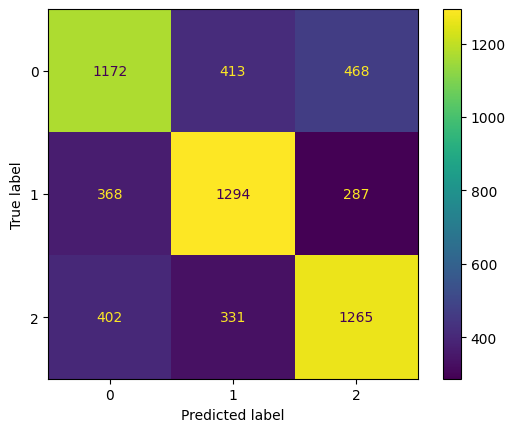

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = "weighted")
conf_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
print("accuracy:", accuracy)
print("f1:", f1)
confusion_matrix_display.plot()


## TF-IDF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfIdf, y, test_size=0.2)

model = LogisticRegression(max_iter = 100_000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

accuracy: 0.694
f1: 0.693770863262102


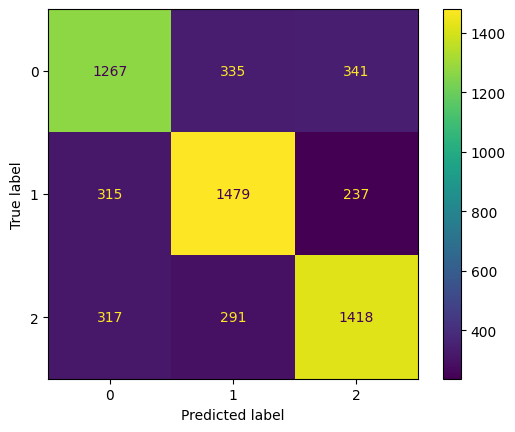

In [ ]:
y_pred_tfIdf = model.predict(X_test)
accuracy_tfIdf = accuracy_score(y_test, y_pred_tfIdf)
f1 = f1_score(y_test, y_pred_tfIdf, average = "weighted")
conf_matrix = confusion_matrix(y_test, y_pred_tfIdf)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
print("accuracy:", accuracy_tfIdf)
print("f1:", f1)
confusion_matrix_display.plot()

## BERT

accuracy: 0.6903333333333334
f1: 0.6903369339055386


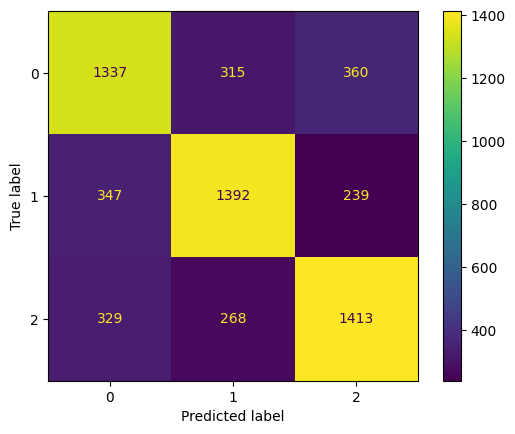

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

model = LogisticRegression(max_iter=10_000) # Increased max_iter to address ConvergenceWarning

X_train, X_test, y_train, y_test = train_test_split(X_bert, y_bert, test_size=0.2)

model.fit(X_train, y_train)

y_pred_bert = model.predict(X_test)

accuracy_bert = accuracy_score(y_test, y_pred_bert)
f1_bert = f1_score(y_test, y_pred_bert, average='weighted') # Added average='weighted' for multiclass F1-score

conf_matrix = confusion_matrix(y_test, y_pred_bert)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)

print("accuracy:", accuracy_bert) # Changed accuracy_tfIdf to accuracy_bert
print("f1:", f1_bert) # Corrected syntax for printing f1_bert
confusion_matrix_display.plot()

# Simple neural network

In [ ]:

import torch.nn as nn


class SimpleNet(nn.Module):
    def __init__(self, input_length):
        super(SimpleNet, self).__init__()
        self.layer1 = nn.Linear(input_length, 200)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(200, 3)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        logits = self.layer2(x)
        return logits


# The SimpleNet class is defined in an earlier cell (6410dfd283fcfc8)
# and should be globally accessible. No need to redefine it here.

def train_network(model, X_train_data, y_train_data):
    # Fix the typo: CrosEntropyLoss -> CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01) # Reduced learning rate for stability

    # Ensure data is on the correct device and type
    X_train_tensor = X_train_data.float() if isinstance(X_train_data, torch.Tensor) else torch.from_numpy(X_train_data).float()
    y_train_tensor = y_train_data.long() if isinstance(y_train_data, torch.Tensor) else torch.from_numpy(y_train_data).long()

    # Move tensors to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)

    for epoch in range(200): # Reduced epochs for faster execution in an example
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0: # Adjusted print frequency
            print(f"Epoch {epoch}: loss={loss.item():.4f}")

def evaluate_model(model, X_test_data, y_test_data):
    # Ensure data is on the correct device and type
    X_test_tensor = X_test_data.float() if isinstance(X_test_data, torch.Tensor) else torch.from_numpy(X_test_data).float()
    y_test_tensor = y_test_data.long() if isinstance(y_test_data, torch.Tensor) else torch.from_numpy(y_test_data).long()

    # Move tensors to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    model.eval()
    with torch.no_grad():
        logits = model(X_test_tensor)
        y_probabilities = F.softmax(logits, dim=1) # Specify dim for softmax
        y_infered = torch.argmax(y_probabilities, dim=1)

        # Move predictions and true labels back to CPU for sklearn metrics
        y_infered_cpu = y_infered.cpu().numpy()
        y_test_cpu = y_test_tensor.cpu().numpy()

        accuaracy = accuracy_score(y_test_cpu, y_infered_cpu)
        f1 = f1_score(y_test_cpu, y_infered_cpu, average='weighted') # For multiclass
        conf_matrix = confusion_matrix(y_test_cpu, y_infered_cpu)
        confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
        print("accuracy:", accuaracy)
        print("f1:", f1)
        confusion_matrix_display.plot()



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
labelEncoder = LabelEncoder()

df = pd.read_csv("preprocessed_data.csv")
y = labelEncoder.fit_transform(df['genre'])
y

array([0, 0, 1, ..., 2, 2, 2])

## TF-IDF

Epoch 0: loss=1.0991
Epoch 20: loss=0.0859
Epoch 40: loss=0.0055
Epoch 60: loss=0.0016
Epoch 80: loss=0.0010
Epoch 100: loss=0.0008
Epoch 120: loss=0.0007
Epoch 140: loss=0.0005
Epoch 160: loss=0.0005
Epoch 180: loss=0.0004
accuracy: 0.6106666666666667
f1: 0.6106853635892833


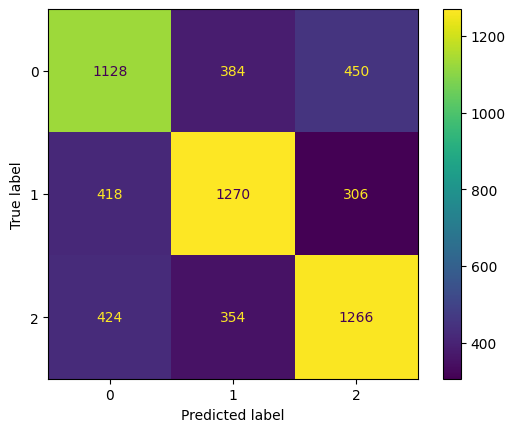

In [ ]:
neuralModel_tfIdf = SimpleNet(16000)
X_train, X_test, y_train, y_test = train_test_split(X_tfIdf, y, test_size=0.2)

train_network(neuralModel_tfIdf, X_train, y_train)
evaluate_model(neuralModel_tfIdf, X_test, y_test )


## Word2Vec

Epoch 0: loss=1.0965
Epoch 20: loss=0.8943
Epoch 40: loss=0.7934
Epoch 60: loss=0.7079
Epoch 80: loss=0.6185
Epoch 100: loss=0.5483
Epoch 120: loss=0.4750
Epoch 140: loss=0.4247
Epoch 160: loss=0.3625
Epoch 180: loss=0.3180
Epoch 200: loss=0.2951
Epoch 220: loss=0.2448
Epoch 240: loss=0.2252
Epoch 260: loss=0.1863
Epoch 280: loss=0.1715
Epoch 300: loss=0.1448
Epoch 320: loss=0.1279
Epoch 340: loss=0.1239
Epoch 360: loss=0.1006
Epoch 380: loss=0.0881
Epoch 400: loss=0.0756
Epoch 420: loss=0.0854
Epoch 440: loss=0.0600
Epoch 460: loss=0.0528
Epoch 480: loss=0.0471
Epoch 500: loss=0.0423
Epoch 520: loss=0.0384
Epoch 540: loss=0.0337
Epoch 560: loss=0.0305
Epoch 580: loss=0.0271
Epoch 600: loss=0.0247
Epoch 620: loss=0.0222
Epoch 640: loss=0.0201
Epoch 660: loss=0.0183
Epoch 680: loss=0.0168
Epoch 700: loss=0.0153
Epoch 720: loss=0.0141
Epoch 740: loss=0.0130
Epoch 760: loss=0.0120
Epoch 780: loss=0.0111
Epoch 800: loss=0.0103
Epoch 820: loss=0.0096
Epoch 840: loss=0.0089
Epoch 860: loss=0

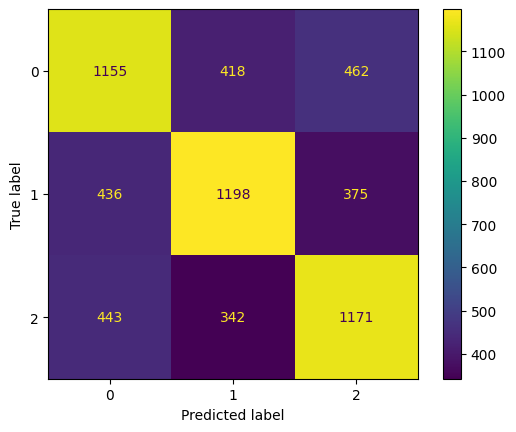

In [ ]:
neuralModel_word2vec = SimpleNet(900)
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2)

train_network(neuralModel_word2vec, X_train, y_train)
evaluate_model(neuralModel_word2vec, X_test, y_test )

## BERT

Epoch 0: loss=1.1037
Epoch 20: loss=1.0950
Epoch 40: loss=1.0883
Epoch 60: loss=1.0725
Epoch 80: loss=0.9907
Epoch 100: loss=0.9101
Epoch 120: loss=0.8691
Epoch 140: loss=0.8417
Epoch 160: loss=0.8222
Epoch 180: loss=0.8013
Epoch 200: loss=0.7944
Epoch 220: loss=0.7934
Epoch 240: loss=0.7806
Epoch 260: loss=0.7819
Epoch 280: loss=0.7837
Epoch 300: loss=0.7654
Epoch 320: loss=0.7632
Epoch 340: loss=0.7615
Epoch 360: loss=0.7559
Epoch 380: loss=0.8149
Epoch 400: loss=0.7561
Epoch 420: loss=0.7504
Epoch 440: loss=0.7497
Epoch 460: loss=0.7443
Epoch 480: loss=0.8040
Epoch 500: loss=0.7462
Epoch 520: loss=0.7402
Epoch 540: loss=0.7382
Epoch 560: loss=0.7352
Epoch 580: loss=0.7390
Epoch 600: loss=0.7376
Epoch 620: loss=0.7333
Epoch 640: loss=0.7367
Epoch 660: loss=0.7439
Epoch 680: loss=0.7316
Epoch 700: loss=0.7268
Epoch 720: loss=0.7319
Epoch 740: loss=0.7251
Epoch 760: loss=0.7220
Epoch 780: loss=0.7295
Epoch 800: loss=0.7254
Epoch 820: loss=0.7220
Epoch 840: loss=0.7138
Epoch 860: loss=0

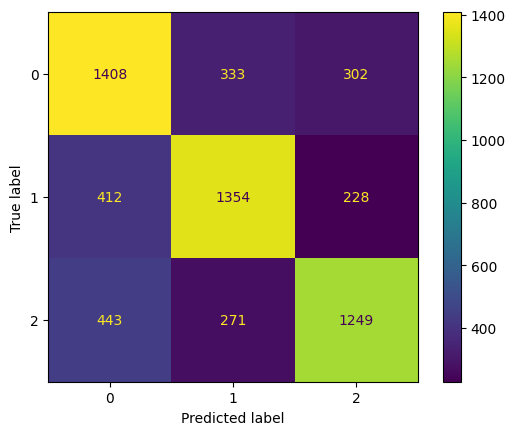

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split # Ensure this is also available
import numpy as np # Required for isinstance check

# The SimpleNet class is defined in an earlier cell (6410dfd283fcfc8)
# and should be globally accessible. No need to redefine it here.

def train_network(model, X_train_data, y_train_data):
    # Fix the typo: CrosEntropyLoss -> CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01) # Reduced learning rate for stability

    # Ensure data is on the correct device and type
    X_train_tensor = X_train_data.float() if isinstance(X_train_data, torch.Tensor) else torch.from_numpy(X_train_data).float()
    y_train_tensor = y_train_data.long() if isinstance(y_train_data, torch.Tensor) else torch.from_numpy(y_train_data).long()

    # Move tensors to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)

    for epoch in range(10_000): # Reduced epochs for faster execution in an example
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0: # Adjusted print frequency
            print(f"Epoch {epoch}: loss={loss.item():.4f}")

def evaluate_model(model, X_test_data, y_test_data):
    # Ensure data is on the correct device and type
    X_test_tensor = X_test_data.float() if isinstance(X_test_data, torch.Tensor) else torch.from_numpy(X_test_data).float()
    y_test_tensor = y_test_data.long() if isinstance(y_test_data, torch.Tensor) else torch.from_numpy(y_test_data).long()

    # Move tensors to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    model.eval()
    with torch.no_grad():
        logits = model(X_test_tensor)
        y_probabilities = F.softmax(logits, dim=1) # Specify dim for softmax
        y_infered = torch.argmax(y_probabilities, dim=1)

        # Move predictions and true labels back to CPU for sklearn metrics
        y_infered_cpu = y_infered.cpu().numpy()
        y_test_cpu = y_test_tensor.cpu().numpy()

        accuaracy = accuracy_score(y_test_cpu, y_infered_cpu)
        f1 = f1_score(y_test_cpu, y_infered_cpu, average='weighted') # For multiclass
        conf_matrix = confusion_matrix(y_test_cpu, y_infered_cpu)
        confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
        print("accuracy:", accuaracy)
        print("f1:", f1)
        confusion_matrix_display.plot()

# Initialize SimpleNet with the correct input length for BERT embeddings (3 * 768 = 2304)
neuralModel_bert = SimpleNet(2304)
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

train_network(neuralModel_bert, X_train, y_train)
evaluate_model(neuralModel_bert, X_test, y_test )